In [1]:
target_size = 288
num_workers = 12

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
tqdm.pandas()
import cv2
import imageio
import os
import sys
import re
import seaborn as sns
import time
import random
import pickle

IMAGE_NUM = 1000
EXAMPLE_NUM = 10
       
SEED = round(time.time())
print(f'SEED: {SEED}')
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

SEED: 1620304170


In [2]:
# sorting again after sampling seems to make the file access slightly faster for large IMAGE_NUM
train_ids = pd.read_csv('../data/train_labels.csv', dtype={'image_id': 'string', 'InChI': 'string'}).sample(n=IMAGE_NUM).sort_values(by='image_id', ignore_index=True).image_id
test_ids = pd.read_csv('../data/sample_submission.csv', usecols=['image_id'], dtype={'image_id': 'string'}).sample(n=IMAGE_NUM).sort_values(by='image_id', ignore_index=True).image_id

The crop function from the original source above was adapted to ignore noise pixels and thus crop the real molecule structure only without removing the noise first.

In [3]:
def crop(img, contour_min_size=2, small_stuff_size=2, small_stuff_dist=5, pad_pixels=1, debug=False, my_figsize=(12,6), horizontal=True, image_id = 0):
    
    # idea: pad with contour_min_size pixels just in case we cut off
    #       a small part of the structure that is separated by a missing pixel
    
    # rotate counter clockwise to get horizontal images
    h, w = img.shape
    if h > w:
        img = np.rot90(img)
    
    if debug:
        if horizontal:
            #fig, ax = plt.subplots(1,4, figsize=my_figsize)
            plt.figure()
        else:
            fig, ax = plt.subplots(4,1, figsize=my_figsize)

        #ax[0].imshow(img, cmap = 'gray')
        #ax[0].set_title(f'original image, shape: {img.shape}', size=8)
        
    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2:]
    
    small_stuff = []
    
    x_min0, y_min0, x_max0, y_max0 = np.inf, np.inf, 0, 0
    for cnt in contours:
        if len(cnt) < contour_min_size:  # ignore contours under contour_min_size pixels
            continue
        x, y, w, h = cv2.boundingRect(cnt)
        if w <= small_stuff_size and h <= small_stuff_size:  # collect position of small contours starting with contour_min_size pixels
            small_stuff.append([x, y, x+w, y+h])
            continue
        x_min0 = min(x_min0, x)
        y_min0 = min(y_min0, y)
        x_max0 = max(x_max0, x + w)
        y_max0 = max(y_max0, y + h)
        
    x_min, y_min, x_max, y_max = x_min0, y_min0, x_max0, y_max0
    
    # enlarge the found crop box if it cuts out small stuff that is very close by
    for i in range(len(small_stuff)):
        if small_stuff[i][0] < x_min0 and small_stuff[i][0] + small_stuff_dist >= x_min0:
             x_min = small_stuff[i][0]
        if small_stuff[i][1] < y_min0 and small_stuff[i][1] + small_stuff_dist >= y_min0:
             y_min = small_stuff[i][1]
        if small_stuff[i][2] > x_max0 and small_stuff[i][2] - small_stuff_dist <= x_max0:
             x_max = small_stuff[i][2]
        if small_stuff[i][3] > y_max0 and small_stuff[i][3] - small_stuff_dist <= y_max0:
             y_max = small_stuff[i][3]
                             
    if pad_pixels > 0:  # make sure we get the crop within a valid range
        y_min = max(0, y_min-pad_pixels)
        y_max = min(img.shape[0], y_max+pad_pixels)
        x_min = max(0, x_min-pad_pixels)
        x_max = min(img.shape[1], x_max+pad_pixels)
        
    img_cropped = img[y_min:y_max, x_min:x_max]

    target_pad = (y_max - y_min) if (y_max - y_min) > (x_max - x_min) else (x_max - x_min)
    target_pad = int(target_pad * 1.1)
    pad_y = (target_pad - (y_max - y_min)) // 2
    pad_x = (target_pad - (x_max - x_min)) // 2
    img_padded = np.pad(img_cropped, ((pad_y, pad_y), (pad_x, pad_x)))

    img_resized = cv2.resize(img_padded, dsize=(target_size, target_size), interpolation=cv2.INTER_CUBIC)
    
    if debug:
        #ax[1].imshow(img_cropped, cmap = 'gray')
        #ax[1].set_title(f'cropped image, shape: {img_cropped.shape}', size=8)
        
        #ax[2].imshow(img_padded, cmap = 'gray')
        #ax[2].set_title(f'padded image, shape: {img_padded.shape}', size=8)

        #ax[3].imshow(img_resized, cmap = 'gray')
        #ax[3].set_title(f'resized image, shape: {img_resized.shape}', size=8)
        fig = plt.gcf()
        fig.set_size_inches(18.5, 10.5)
        plt.imshow(img_resized, cmap = 'gray')
        #plt.set_title(f'resized image, shape: {img_resized.shape}', size=8)

        plt.show()
    
    return img_resized

In [4]:
def check_cropping(image_id, folder='train', my_figsize=(30,15), horizontal=True, debug=False):
    #print(f'{folder}/{image_id}')
    file_path =  f'../data/{folder}/{image_id[0]}/{image_id[1]}/{image_id[2]}/{image_id}.png'
    img = 255 - cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    img = crop(img, debug=debug, my_figsize=my_figsize, horizontal=horizontal, image_id= image_id)
    return img

def check_cropping_train(image_id, folder='train', my_figsize=(30,15), horizontal=True, debug=False):
    #print(f'{folder}/{image_id}')
    file_path =  f'../data/{folder}/{image_id[0]}/{image_id[1]}/{image_id[2]}/{image_id}.png'
    img = 255 - cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    img = crop(img, debug=False, my_figsize=my_figsize, horizontal=horizontal, image_id= image_id)
    return img

def check_cropping_test(image_id, folder='test', my_figsize=(30,15), horizontal=True, debug=False):
    #print(f'{folder}/{image_id}')
    file_path =  f'../data/{folder}/{image_id[0]}/{image_id[1]}/{image_id[2]}/{image_id}.png'
    img = 255 - cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    img = crop(img, debug=False, my_figsize=my_figsize, horizontal=horizontal, image_id= image_id)
    return img

def check_cropping_synthetic(image_id, folder='synthetic_train', my_figsize=(30,15), horizontal=True, debug=False):
    #print(f'{folder}/{image_id}')
    file_path =  f'../data/{folder}/{image_id[0]}/{image_id[1]}/{image_id[2]}/{image_id}.png'
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    img = crop(img, debug=False, my_figsize=my_figsize, horizontal=horizontal, image_id= image_id)
    return img

def one_over_synthetic(image_id, folder='synthetic_train', my_figsize=(30,15), horizontal=True, debug=False):
    #print(f'{folder}/{image_id}')
    file_path =  f'../data/{folder}/{image_id[0]}/{image_id[1]}/{image_id[2]}/{image_id}.png'
    img = 255 - cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    return img


# Check cropped train images

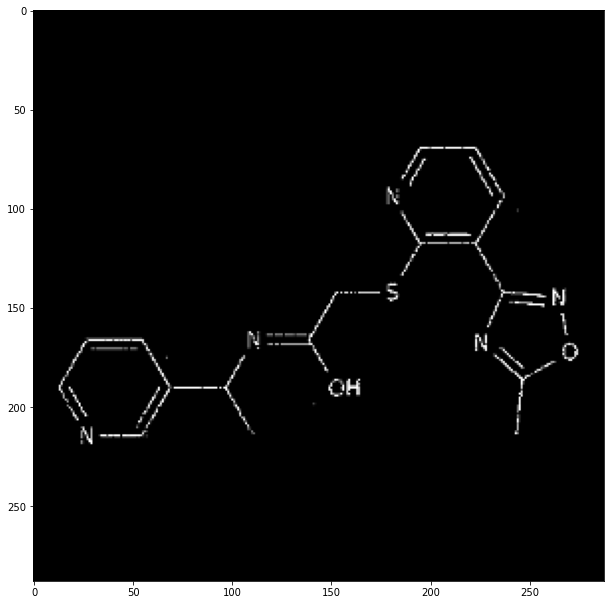

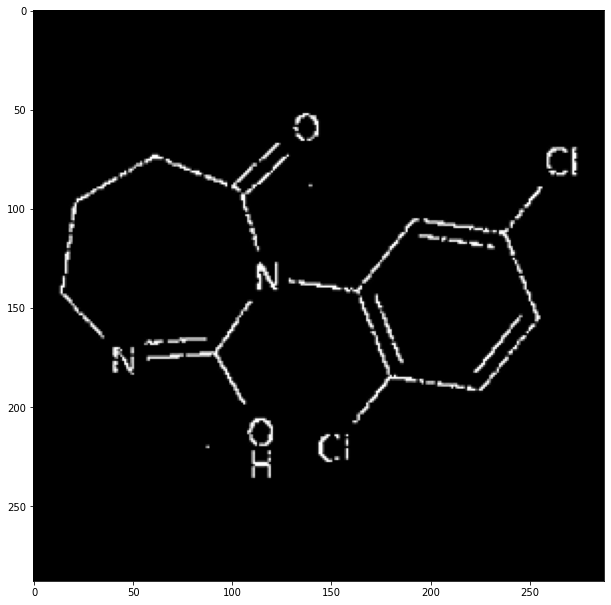

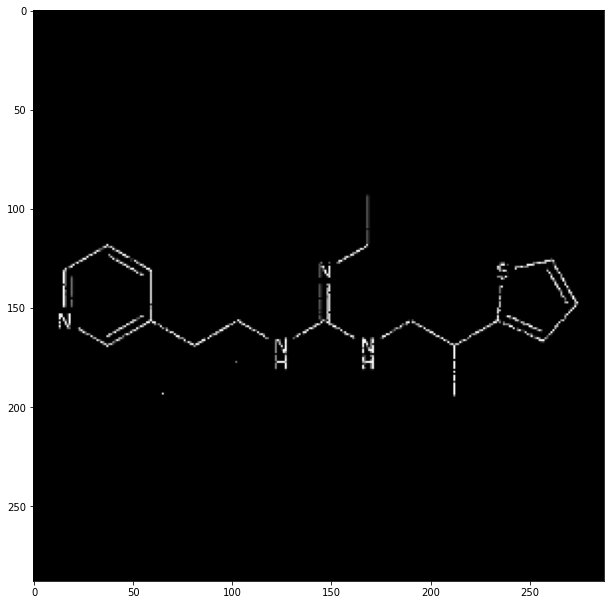

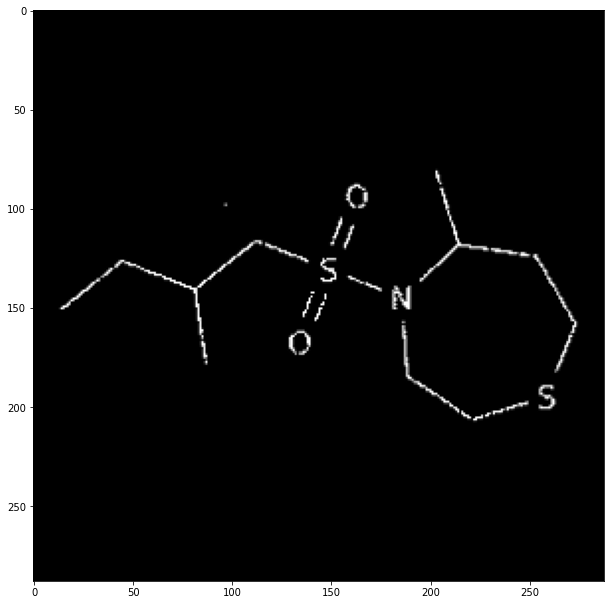

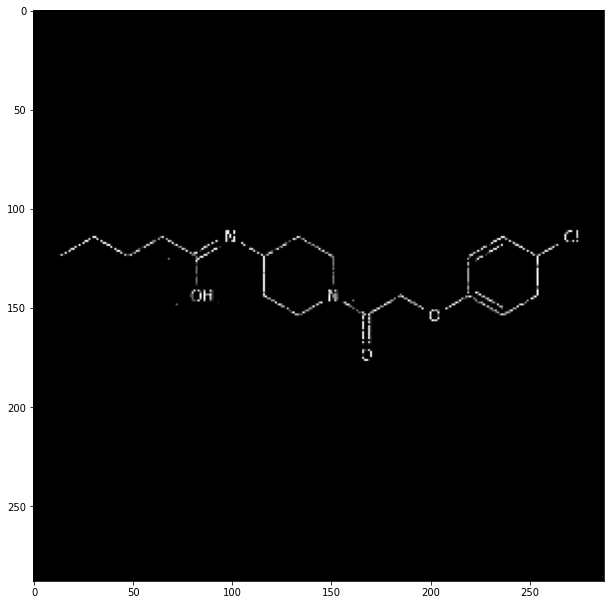

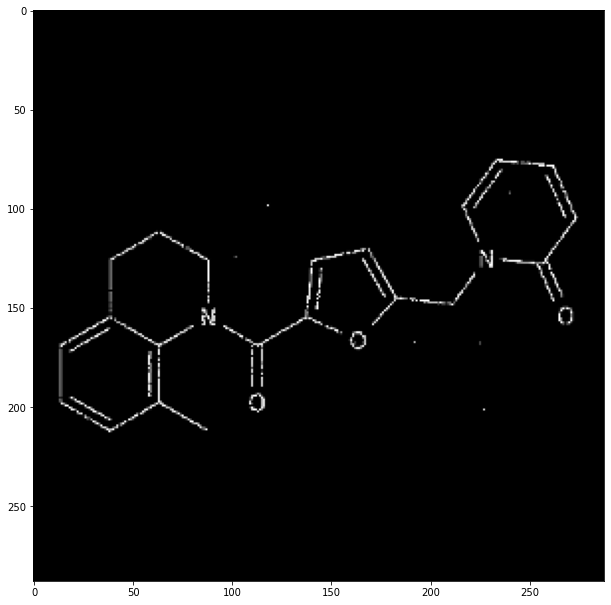

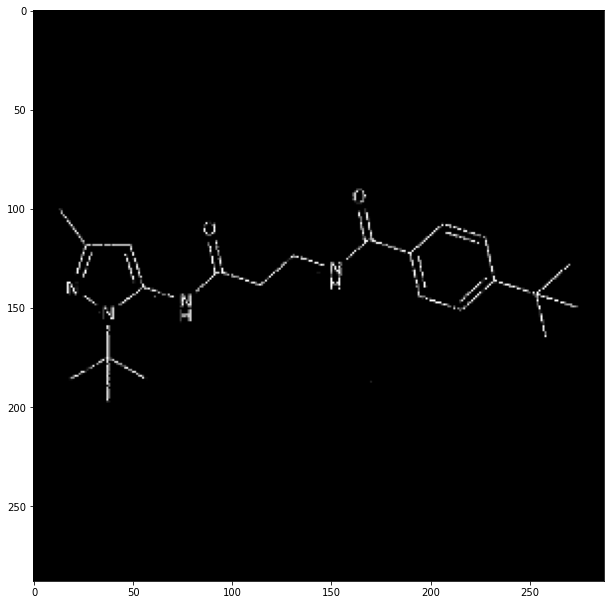

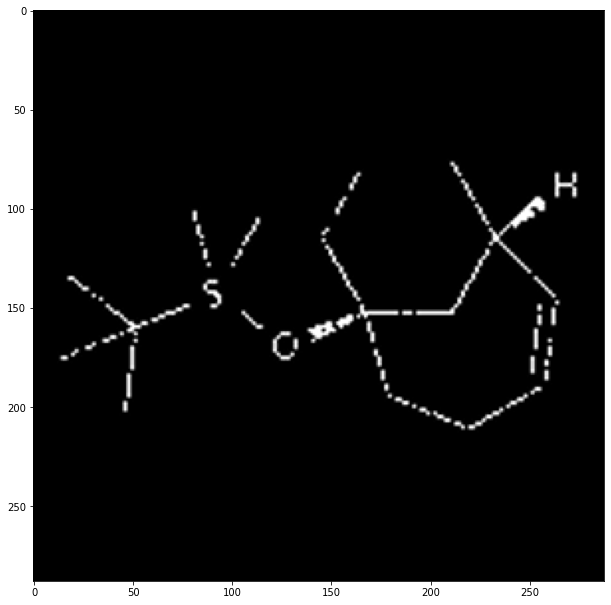

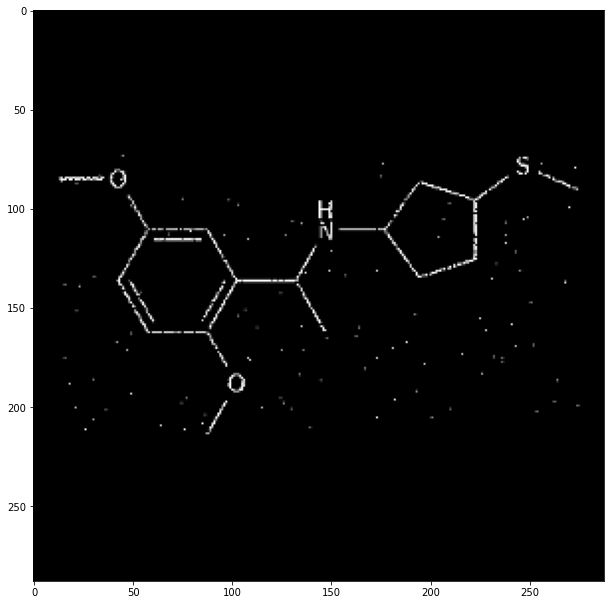

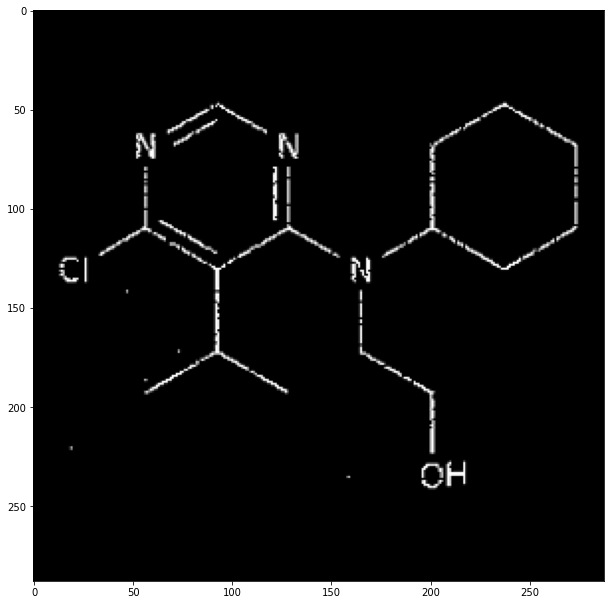

In [5]:
dummy = [check_cropping(image_id, folder='train', debug=True) for image_id in train_ids[:EXAMPLE_NUM]]

# Check cropped test images

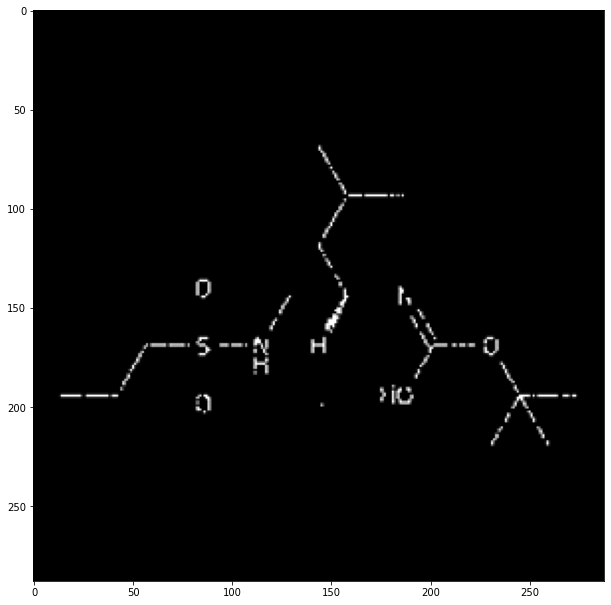

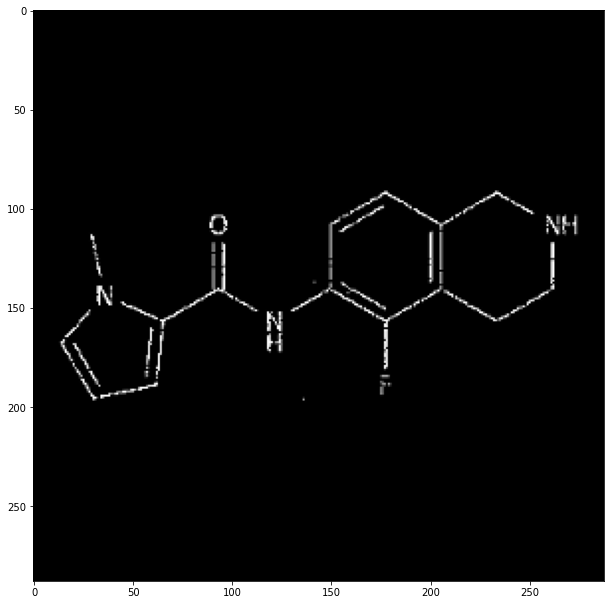

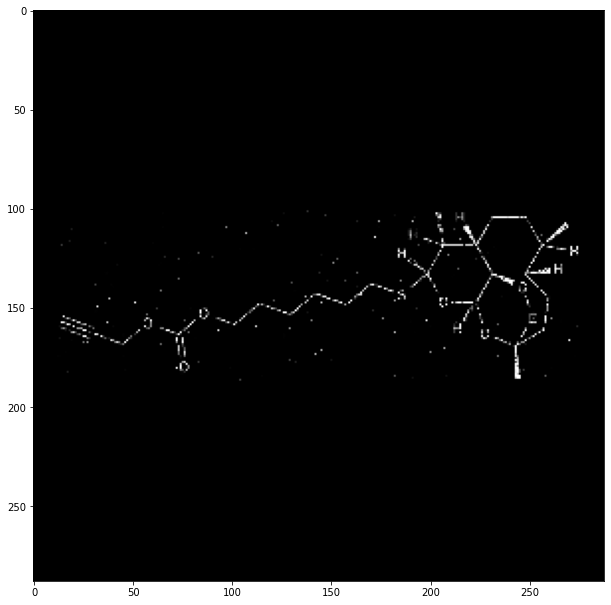

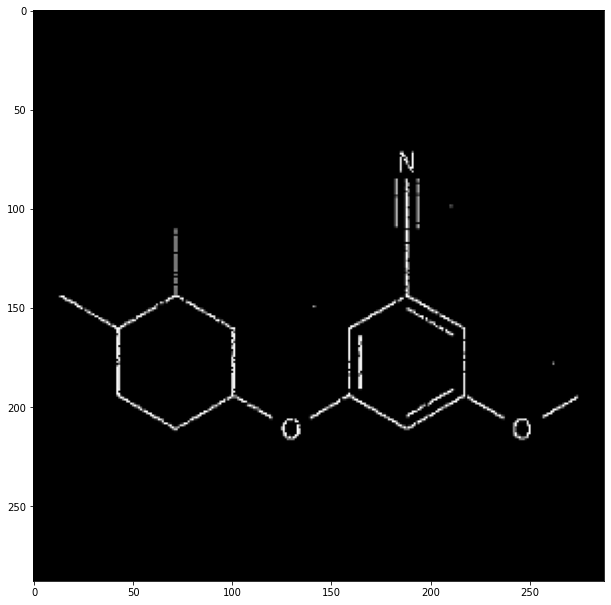

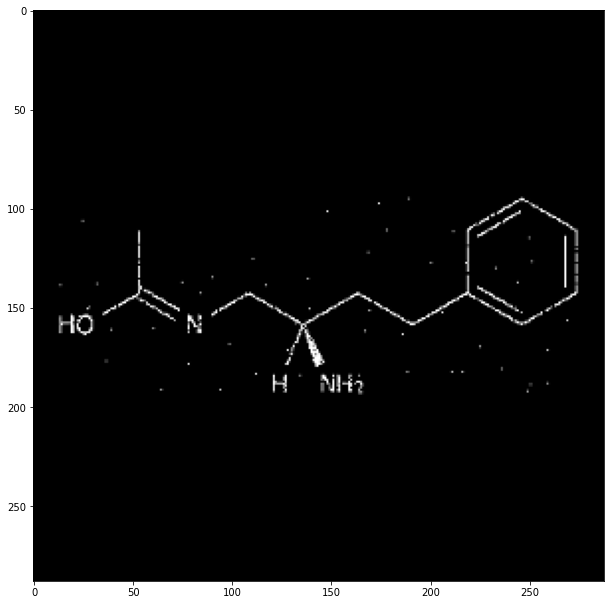

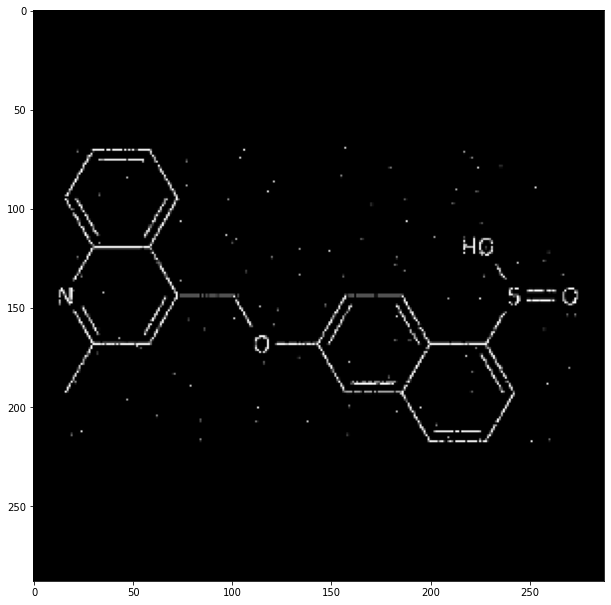

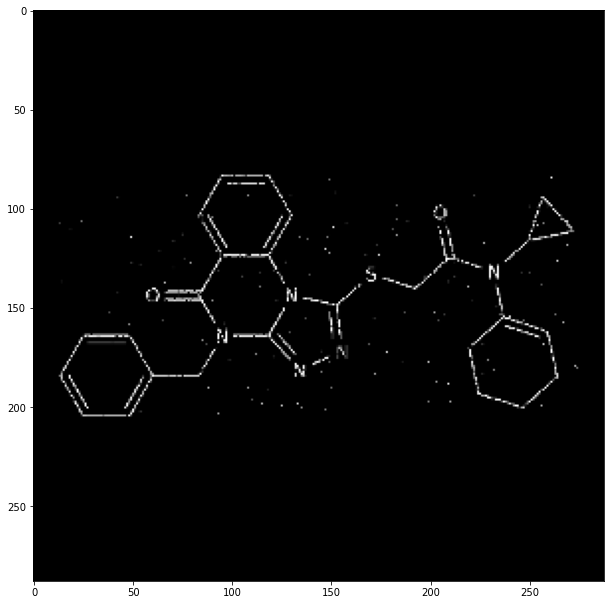

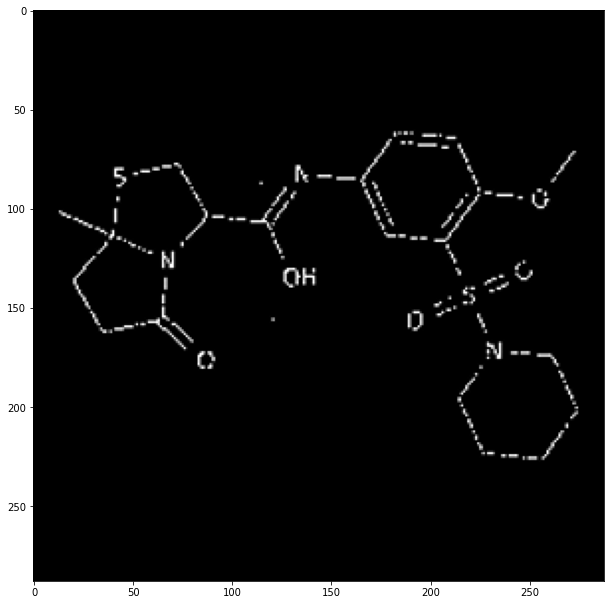

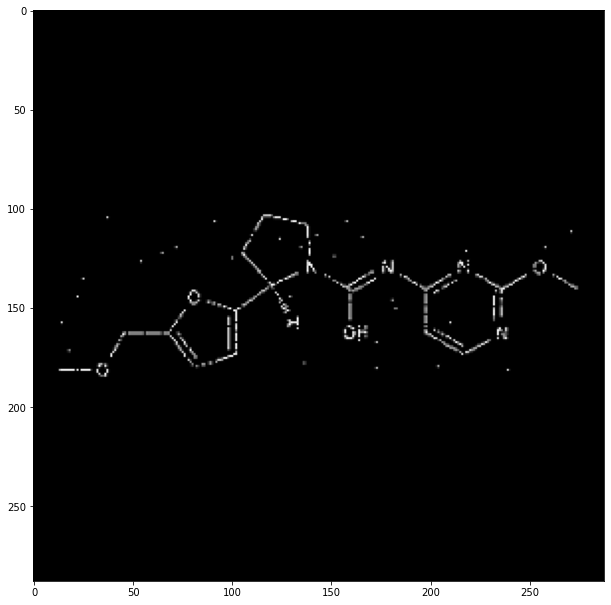

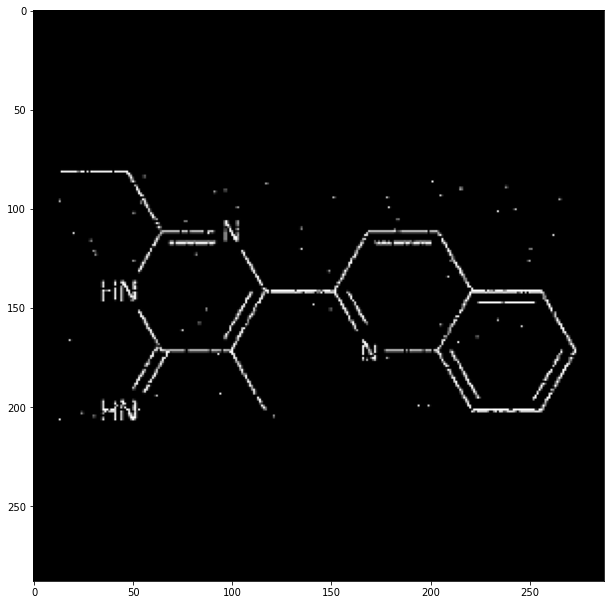

In [6]:
dummy = [check_cropping(image_id, folder='test', debug=True) for image_id in test_ids[:EXAMPLE_NUM]]

# Find extreme image

In [7]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

def analyse_img_sizes(image_ids, folder='train', plots=False, w_large=500, h_large=250, very_large_factor=1.5):
    ws = []
    hs = []
    ws_c = []
    hs_c = []
    fs = []
    for image_id in tqdm(image_ids):
        file_path =  f'../data/{folder}/{image_id[0]}/{image_id[1]}/{image_id[2]}/{image_id}.png'
        file_size = os.path.getsize(file_path) 
        fs.append(file_size)
        img = 255 - cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # '255 -' need for cropping to work

        h, w = img.shape
        if h > w:
            h, w = w, h
        ws.append(w)
        hs.append(h)

        img_cropped = crop(img)
        h_c, w_c = img_cropped.shape
        if h_c > w_c:
            h_c, w_c = w_c, h_c
        ws_c.append(w_c)
        hs_c.append(h_c)

    img_info = pd.DataFrame({'image_id': image_ids, 'file_size': fs, 'width': ws, 'width_crop': ws_c, 'height': hs, 'height_crop': hs_c})
    
    img_info['area'] = img_info.width * img_info.height
    img_info['area_crop'] = img_info.width_crop * img_info.height_crop
    img_info['ratio'] = img_info.width / img_info.height
    img_info['ratio_crop'] = img_info.width_crop / img_info.height_crop
        
    img_info_large = img_info.loc[np.logical_or(img_info.width_crop > w_large, img_info.height_crop > h_large),:]
    
    img_info_very_large = img_info.loc[np.logical_or(img_info.width_crop > very_large_factor*w_large, img_info.height_crop > very_large_factor*h_large),:]
        
    print(f'statistics for all images')
    display(img_info.describe())
    print()
    print(f"statistics for 'large' images with cropped width > {w_large} or height > {h_large} ({len(img_info_large)/len(img_info)*100:.3}%):")
    display(img_info_large.describe())
    print()
    print(f"statistics for 'very large' images with cropped width > {very_large_factor*w_large} or height > {very_large_factor*h_large} ({len(img_info_very_large)/len(img_info)*100:.3}%):")
    display(img_info_very_large.describe())
    
    if plots:
        print()
        print(f"plots for 'large' and 'very large' images only")
        plot_info =  img_info_large
        sns.jointplot(data=plot_info, x='width', y='height', kind='hist')
        sns.jointplot(data=plot_info, x='file_size', y='area', kind='hist')
        sns.jointplot(data=plot_info, x='width', y='width_crop', kind='hist')
        sns.jointplot(data=plot_info, x='height', y='height_crop', kind='hist')
        sns.jointplot(data=plot_info, x='width_crop', y='height_crop', kind='hist')
        sns.jointplot(data=plot_info, x='ratio', y='ratio_crop', kind='hist')
        sns.jointplot(data=plot_info, x='area_crop', y='ratio_crop', kind='hist')

    return img_info

  0%|          | 0/1000 [00:00<?, ?it/s]

statistics for all images


file_size   width  width_crop  height  height_crop      area  \
count    1000.00 1000.00     1000.00 1000.00      1000.00   1000.00   
mean     1645.76  375.70      288.00  219.05       288.00  88131.20   
std       734.80  130.58        0.00   68.59         0.00  57003.74   
min       502.00  143.00      288.00  101.00       288.00  18018.00   
25%      1083.25  279.00      288.00  164.00       288.00  46028.75   
50%      1507.50  354.50      288.00  214.00       288.00  75209.00   
75%      2068.00  449.00      288.00  259.25       288.00 115745.25   
max      6256.00 1424.00      288.00  776.00       288.00 886192.00   

       area_crop   ratio  ratio_crop  
count    1000.00 1000.00     1000.00  
mean    82944.00    1.76        1.00  
std         0.00    0.48        0.00  
min     82944.00    1.01        1.00  
25%     82944.00    1.41        1.00  
50%     82944.00    1.69        1.00  
75%     82944.00    2.00        1.00  
max     82944.00    6.15        1.00


statistics for 'large' images with cropped width > 500 or height > 250 (1e+02%):


file_size   width  width_crop  height  height_crop      area  \
count    1000.00 1000.00     1000.00 1000.00      1000.00   1000.00   
mean     1645.76  375.70      288.00  219.05       288.00  88131.20   
std       734.80  130.58        0.00   68.59         0.00  57003.74   
min       502.00  143.00      288.00  101.00       288.00  18018.00   
25%      1083.25  279.00      288.00  164.00       288.00  46028.75   
50%      1507.50  354.50      288.00  214.00       288.00  75209.00   
75%      2068.00  449.00      288.00  259.25       288.00 115745.25   
max      6256.00 1424.00      288.00  776.00       288.00 886192.00   

       area_crop   ratio  ratio_crop  
count    1000.00 1000.00     1000.00  
mean    82944.00    1.76        1.00  
std         0.00    0.48        0.00  
min     82944.00    1.01        1.00  
25%     82944.00    1.41        1.00  
50%     82944.00    1.69        1.00  
75%     82944.00    2.00        1.00  
max     82944.00    6.15        1.00


statistics for 'very large' images with cropped width > 750.0 or height > 375.0 (0.0%):


file_size  width  width_crop  height  height_crop  area  area_crop  \
count       0.00   0.00        0.00    0.00         0.00  0.00       0.00   
mean         NaN    NaN         NaN     NaN          NaN   NaN        NaN   
std          NaN    NaN         NaN     NaN          NaN   NaN        NaN   
min          NaN    NaN         NaN     NaN          NaN   NaN        NaN   
25%          NaN    NaN         NaN     NaN          NaN   NaN        NaN   
50%          NaN    NaN         NaN     NaN          NaN   NaN        NaN   
75%          NaN    NaN         NaN     NaN          NaN   NaN        NaN   
max          NaN    NaN         NaN     NaN          NaN   NaN        NaN   

       ratio  ratio_crop  
count   0.00        0.00  
mean     NaN         NaN  
std      NaN         NaN  
min      NaN         NaN  
25%      NaN         NaN  
50%      NaN         NaN  
75%      NaN         NaN  
max      NaN         NaN


plots for 'large' and 'very large' images only


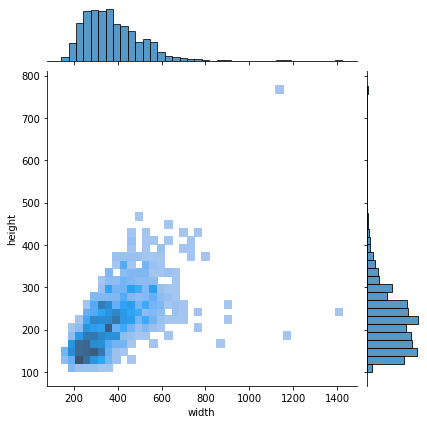

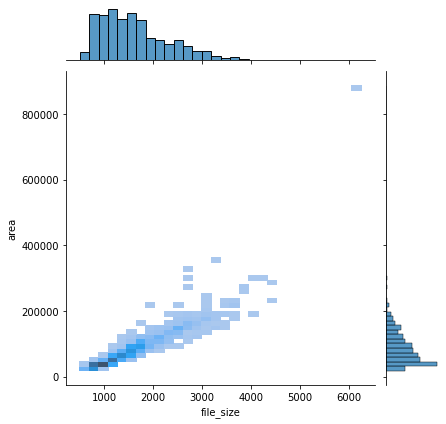

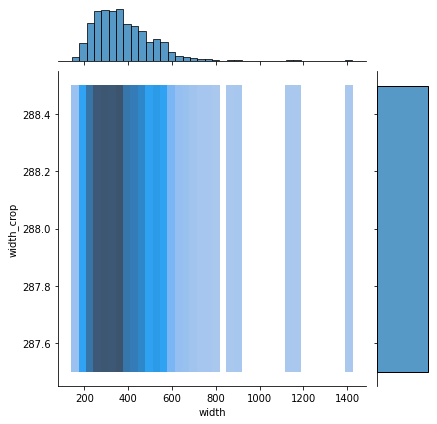

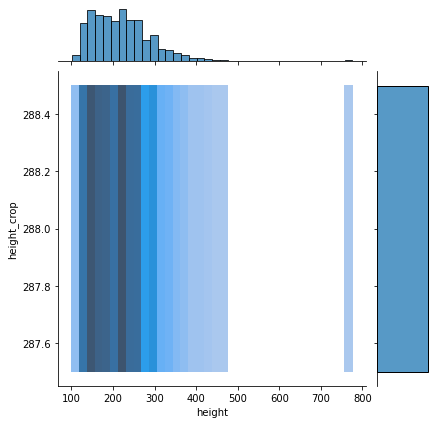

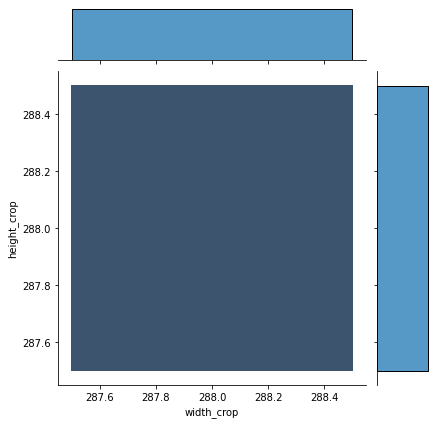

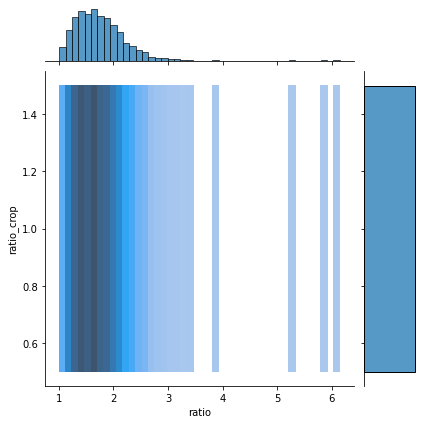

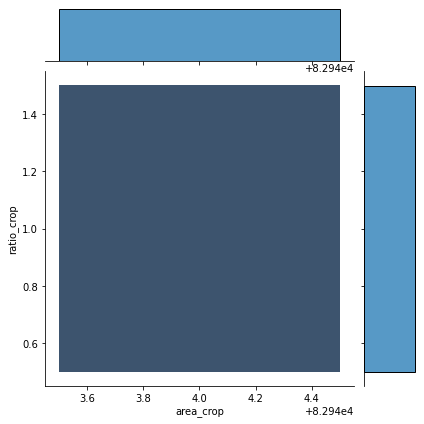

In [8]:
train_img_info = analyse_img_sizes(train_ids, folder='train', plots=True)

with open('train_img_info.pkl', 'wb') as handle:
    pickle.dump(train_img_info, handle)

  0%|          | 0/1000 [00:00<?, ?it/s]

statistics for all images


file_size   width  width_crop  height  height_crop       area  \
count    1000.00 1000.00     1000.00 1000.00      1000.00    1000.00   
mean     1959.53  384.45      288.00  220.87       288.00   93540.34   
std      1120.66  140.93        0.00   82.09         0.00   85959.05   
min       573.00  138.00      288.00  103.00       288.00   16284.00   
25%      1196.00  279.75      288.00  160.00       288.00   44708.25   
50%      1686.50  362.00      288.00  209.00       288.00   76368.00   
75%      2449.50  460.00      288.00  262.00       288.00  116921.25   
max     14106.00 1468.00      288.00 1087.00       288.00 1377229.00   

       area_crop   ratio  ratio_crop  
count    1000.00 1000.00     1000.00  
mean    82944.00    1.79        1.00  
std         0.00    0.45        0.00  
min     82944.00    1.01        1.00  
25%     82944.00    1.45        1.00  
50%     82944.00    1.74        1.00  
75%     82944.00    2.05        1.00  
max     82944.00    4.10        1.00


statistics for 'large' images with cropped width > 500 or height > 250 (1e+02%):


file_size   width  width_crop  height  height_crop       area  \
count    1000.00 1000.00     1000.00 1000.00      1000.00    1000.00   
mean     1959.53  384.45      288.00  220.87       288.00   93540.34   
std      1120.66  140.93        0.00   82.09         0.00   85959.05   
min       573.00  138.00      288.00  103.00       288.00   16284.00   
25%      1196.00  279.75      288.00  160.00       288.00   44708.25   
50%      1686.50  362.00      288.00  209.00       288.00   76368.00   
75%      2449.50  460.00      288.00  262.00       288.00  116921.25   
max     14106.00 1468.00      288.00 1087.00       288.00 1377229.00   

       area_crop   ratio  ratio_crop  
count    1000.00 1000.00     1000.00  
mean    82944.00    1.79        1.00  
std         0.00    0.45        0.00  
min     82944.00    1.01        1.00  
25%     82944.00    1.45        1.00  
50%     82944.00    1.74        1.00  
75%     82944.00    2.05        1.00  
max     82944.00    4.10        1.00


statistics for 'very large' images with cropped width > 750.0 or height > 375.0 (0.0%):


file_size  width  width_crop  height  height_crop  area  area_crop  \
count       0.00   0.00        0.00    0.00         0.00  0.00       0.00   
mean         NaN    NaN         NaN     NaN          NaN   NaN        NaN   
std          NaN    NaN         NaN     NaN          NaN   NaN        NaN   
min          NaN    NaN         NaN     NaN          NaN   NaN        NaN   
25%          NaN    NaN         NaN     NaN          NaN   NaN        NaN   
50%          NaN    NaN         NaN     NaN          NaN   NaN        NaN   
75%          NaN    NaN         NaN     NaN          NaN   NaN        NaN   
max          NaN    NaN         NaN     NaN          NaN   NaN        NaN   

       ratio  ratio_crop  
count   0.00        0.00  
mean     NaN         NaN  
std      NaN         NaN  
min      NaN         NaN  
25%      NaN         NaN  
50%      NaN         NaN  
75%      NaN         NaN  
max      NaN         NaN


plots for 'large' and 'very large' images only


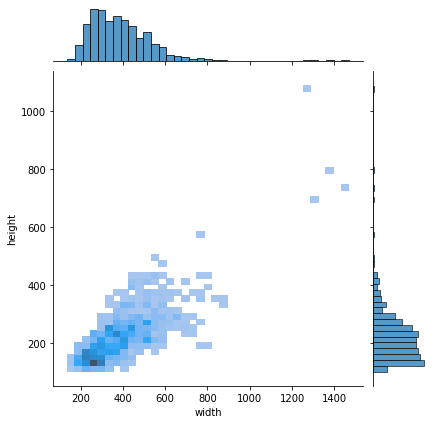

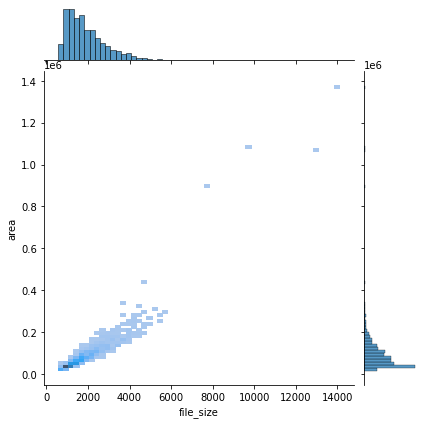

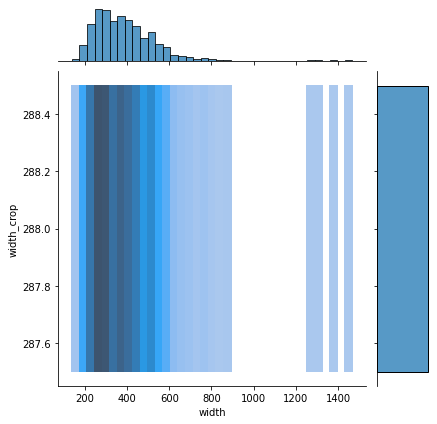

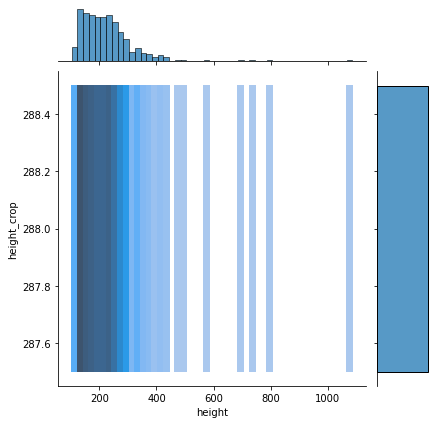

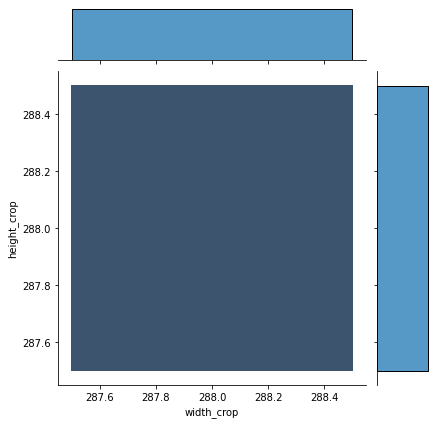

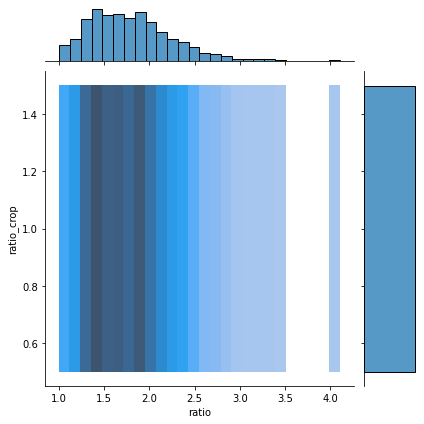

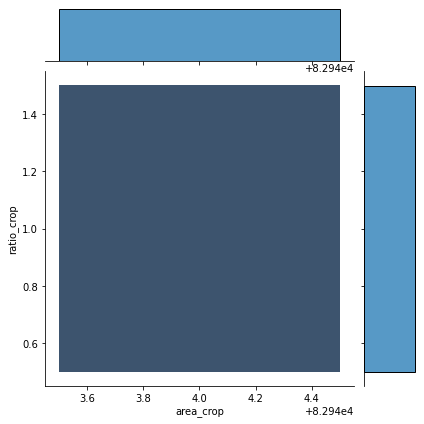

In [9]:
test_img_info = analyse_img_sizes(test_ids, folder='test', plots=True)

with open('test_img_info.pkl', 'wb') as handle:
    pickle.dump(test_img_info, handle)

In [10]:
def plot_extreme_images(img_info, folder='train', my_figsize = (30,15)):
    img_info_width = img_info.sort_values(by='width_crop', ignore_index=True)[:EXAMPLE_NUM]
    img_info_height = img_info.sort_values(by='height_crop', ignore_index=True)[:EXAMPLE_NUM]
    
    print('very low height images (after swapping if height > width)')
    [check_cropping(image_id, folder=folder, my_figsize=my_figsize, horizontal=True) for image_id in img_info_height.image_id]
    
    print('very low width images (after swapping if height > width)')
    [check_cropping(image_id, folder=folder, my_figsize=my_figsize, horizontal=True) for image_id in img_info_width.image_id]

plot_extreme_images(train_img_info)

very low height images (after swapping if height > width)
very low width images (after swapping if height > width)


In [11]:
plot_extreme_images(test_img_info, folder='test')

very low height images (after swapping if height > width)
very low width images (after swapping if height > width)


# Save all processed images

In [12]:
# sorting again after sampling seems to make the file access slightly faster for large IMAGE_NUM
train_ids = pd.read_csv('../data/train_labels.csv', dtype={'image_id': 'string', 'InChI': 'string'}).image_id
test_ids = pd.read_csv('../data/sample_submission.csv', usecols=['image_id'], dtype={'image_id': 'string'}).image_id
print(len(train_ids))
print(len(test_ids))

2424186
1616107


In [13]:
def process_and_save_train(image_id):
    target_folder = 'train'
    img = check_cropping_train(image_id, debug=False)
    save_file_path =  f'../data/processed_{target_folder}/{image_id[0]}/{image_id[1]}/{image_id[2]}/{image_id}.png'
    if not os.path.exists(f'../data/processed_{target_folder}/{image_id[0]}'):
        os.makedirs(f'../data/processed_{target_folder}/{image_id[0]}')
    if not os.path.exists(f'../data/processed_{target_folder}/{image_id[0]}/{image_id[1]}'):
        os.makedirs(f'../data/processed_{target_folder}/{image_id[0]}/{image_id[1]}')
    if not os.path.exists(f'../data/processed_{target_folder}/{image_id[0]}/{image_id[1]}/{image_id[2]}'):
        os.makedirs(f'../data/processed_{target_folder}/{image_id[0]}/{image_id[1]}/{image_id[2]}')
    cv2.imwrite(save_file_path, img)

def process_and_save_test(image_id):
    target_folder = 'test'
    img = check_cropping_test(image_id, debug=False)
    save_file_path =  f'../data/processed_{target_folder}/{image_id[0]}/{image_id[1]}/{image_id[2]}/{image_id}.png'
    if not os.path.exists(f'../data/processed_{target_folder}/{image_id[0]}'):
        os.makedirs(f'../data/processed_{target_folder}/{image_id[0]}')
    if not os.path.exists(f'../data/processed_{target_folder}/{image_id[0]}/{image_id[1]}'):
        os.makedirs(f'../data/processed_{target_folder}/{image_id[0]}/{image_id[1]}')
    if not os.path.exists(f'../data/processed_{target_folder}/{image_id[0]}/{image_id[1]}/{image_id[2]}'):
        os.makedirs(f'../data/processed_{target_folder}/{image_id[0]}/{image_id[1]}/{image_id[2]}')
    cv2.imwrite(save_file_path, img)

def process_and_save_synthetic(image_id):
    target_folder = 'synthetic_train'
    img = check_cropping_synthetic(image_id, debug=False)
    save_file_path =  f'../data/processed_{target_folder}/{image_id[0]}/{image_id[1]}/{image_id[2]}/{image_id}.png'
    if not os.path.exists(f'../data/processed_{target_folder}/{image_id[0]}'):
        os.makedirs(f'../data/processed_{target_folder}/{image_id[0]}')
    if not os.path.exists(f'../data/processed_{target_folder}/{image_id[0]}/{image_id[1]}'):
        os.makedirs(f'../data/processed_{target_folder}/{image_id[0]}/{image_id[1]}')
    if not os.path.exists(f'../data/processed_{target_folder}/{image_id[0]}/{image_id[1]}/{image_id[2]}'):
        os.makedirs(f'../data/processed_{target_folder}/{image_id[0]}/{image_id[1]}/{image_id[2]}')
    cv2.imwrite(save_file_path, img)


def process_and_save_one_over_synthetic(image_id):
    target_folder = 'synthetic_train_one_over'
    img = one_over_synthetic(image_id, debug=False)
    save_file_path =  f'../data/processed_{target_folder}/{image_id[0]}/{image_id[1]}/{image_id[2]}/{image_id}.png'
    if not os.path.exists(f'../data/processed_{target_folder}/{image_id[0]}'):
        os.makedirs(f'../data/processed_{target_folder}/{image_id[0]}')
    if not os.path.exists(f'../data/processed_{target_folder}/{image_id[0]}/{image_id[1]}'):
        os.makedirs(f'../data/processed_{target_folder}/{image_id[0]}/{image_id[1]}')
    if not os.path.exists(f'../data/processed_{target_folder}/{image_id[0]}/{image_id[1]}/{image_id[2]}'):
        os.makedirs(f'../data/processed_{target_folder}/{image_id[0]}/{image_id[1]}/{image_id[2]}')
    cv2.imwrite(save_file_path, img)

In [14]:
from multiprocessing import Pool

if not os.path.exists(f'../data/processed_train'):
    os.makedirs(f'../data/processed_train')

if not os.path.exists(f'../data/processed_test'):
    os.makedirs(f'../data/processed_test')

# start_time = time.time()
# print('start processing the train data')
# train_pool = Pool()
# train_pool.map(process_and_save_train, train_ids)
# train_pool.close()
# train_pool.join()
# end_time = time.time()
# print('finish processing the train data')
# print('Used', end_time - start_time, 'seconds')

start_time = time.time()
print('start processing the test data')
test_pool = Pool()
test_pool.map(process_and_save_test, test_ids)
test_pool.close()
test_pool.join()
end_time = time.time()
print('finish processing the test data')
print('Used', end_time - start_time, 'seconds')

# start_time = time.time()
# print('start processing the one over synthetic data')
# synthetic_one_over_pool = Pool()
# synthetic_one_over_pool.map(process_and_save_one_over_synthetic, train_ids)
# synthetic_one_over_pool.close()
# synthetic_one_over_pool.join()
# end_time = time.time()
# print('finish processing the synthetic data')
# print('Used', end_time - start_time, 'seconds')

# start_time = time.time()
# print('start processing the synthetic data')
# synthetic_pool = Pool()
# synthetic_pool.map(process_and_save_synthetic, train_ids)
# synthetic_pool.close()
# synthetic_pool.join()
# end_time = time.time()
# print('finish processing the synthetic data')
# print('Used', end_time - start_time, 'seconds')


start processing the synthetic data
finish processing the synthetic data
Used 310.08123803138733 seconds
